<a href="https://colab.research.google.com/github/klngithubsairam/Research/blob/master/AutoEncoder_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


(536, 7)
(133, 7)
(224, 7)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 455       
Total params: 6,215
Trainable params: 6,215
Non-trainable params: 0
_________________________

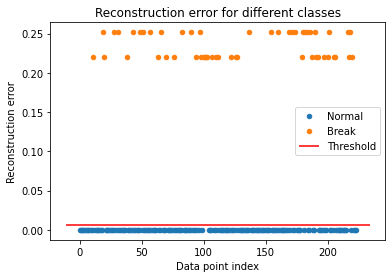

==Confusion matrix==
[[171   0]
 [  0  53]]


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import seaborn as sns

# load dataset
df = pd.read_csv("/content/gdrive/My Drive/Reentrancy_dataset.csv",delimiter=',')

df2_train, df2_test = train_test_split(df, test_size=0.2,random_state=123 )
df2_train, df2_valid = train_test_split(df2_train, test_size=0.2,random_state=123)

train_data21 = df2_train.loc[df2_train['Label'] == 0, ['Send', 'call', 'dc', 'if', 'mscv','bv','bms', 'Label']]
val_data21 = df2_valid.loc[df2_valid['Label'] == 0, ['Send', 'call', 'dc', 'if', 'mscv','bv','bms', 'Label']]

train_data2= train_data21.drop(['Label'], axis=1)
val_data2=val_data21.drop(['Label'], axis=1)
test_data2=df2_test.drop(['Label'], axis=1)

print(train_data2.shape)
print(val_data2.shape)
print(test_data2.shape)

batch_size = 64
input_dim = 7 
encoding_dim = 64
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_data2, train_data2,
                    epochs=20,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(val_data2, val_data2),
                    verbose=1,
                    callbacks=[cp, tb]).history

test_x_predictions = autoencoder.predict(test_data2)
t=test_data2.values
mse = np.mean(np.power(t - test_x_predictions, 2), axis=1)  
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df2_test['Label']})
error_df_test = error_df_test.reset_index()

threshold_fixed = 0.006
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=4.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, pred_y)
print("==Confusion matrix==")
print(conf_matrix)
#plt.figure(figsize=(5, 5))
#sns.heatmap(conf_matrix, annot=True, fmt="d");
#plt.title("Confusion matrix")
#plt.ylabel('True class')
#plt.xlabel('Predicted class')
#plt.show()
